## 🚀 Ракетный фильтр на службе геофизика
В прошлом ноутбуке мы создавали трапециевидный фильтр, который потом сглаживали. 
Каждый, кто работает с сейсмическими данными, хорошо знает этот фильтр. Он называется ```Ormsby Filter```, а его имульсный отклик - ```Orsmby Wavelet``` (его иногда используют для синтетики наряду с классическим импульсом Рикера). 
Но редко кто задумывается, что впервые этот фильтр был описан в статье про обработку ракетных данных!
В 1960-е годы Джон Ормсби опубликовал работу ```"Design of numerical filters with applications to missile data processing"```, 
где предложил удобный способ строить цифровые полосовые фильтры с трапециевидной АЧХ.

Для своего времени это было важное новшество:

* до Ормсби стандартными были фильтры с прямоугольным «окном» в спектре, что вызывало сильные искажения;

* трапециевидная форма давала более плавный переход к нулю и контролируемую полосу пропускания.


В этом ноутбуке создадим фильтр Ормсби, рассмотрим его импульсный отклик (он же Ormsby wavelet) и сравним с ещё одним популярным фильтром Баттервота

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Создадим функцию задания фильтра Ормсби по 4-м частотам, dt, nt и fmax, а также формирование импульсного отклика через обратное преобразование Фурье

In [2]:
def ormsby_wavelet(f1, f2, f3, f4, dt=0.001, nt=1024):
    t = np.arange(-nt//2, nt//2) * dt
    df = 1.0 / (nt * dt)
    freqs = np.fft.fftfreq(nt, d=dt)
    freqs = np.fft.fftshift(freqs)
    
    H = np.zeros(nt)
    for i, f in enumerate(freqs):
        if f1 <= f <= f2:
            H[i] = (f - f1) / (f2 - f1)
        elif f2 < f <= f3:
            H[i] = 1.0
        elif f3 < f <= f4:
            H[i] = (f4 - f) / (f4 - f3)
        # для отрицательных частот — симметрия (real signal)
        elif -f4 <= f < -f3:
            H[i] = (f4 + f) / (f4 - f3)
        elif -f3 <= f < -f2:
            H[i] = 1.0
        elif -f2 <= f < -f1:
            H[i] = (-f - f1) / (f2 - f1)
    
    wavelet = np.fft.ifft(np.fft.ifftshift(H)).real
    wavelet = np.fft.fftshift(wavelet)
    wavelet /= np.abs(wavelet).max()
    
    # положительные частоты для АЧХ
    pos = freqs >= 0
    return freqs[pos], H[pos], t, wavelet

### АЧХ и импульсный отклик
📈 Частотная характеристика Ормсби-фильтра
Трапеция с заданными частотами обрезки f1, f2, f3, f4.

📉 Импульсный отклик (Ormsby wavelet)
Колеблющийся импульс, возникающий как результат ограниченной полосы.

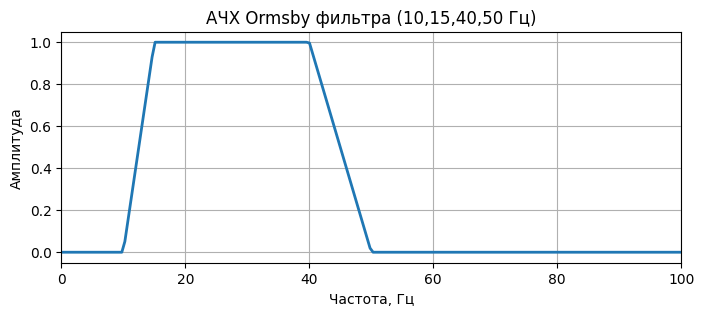

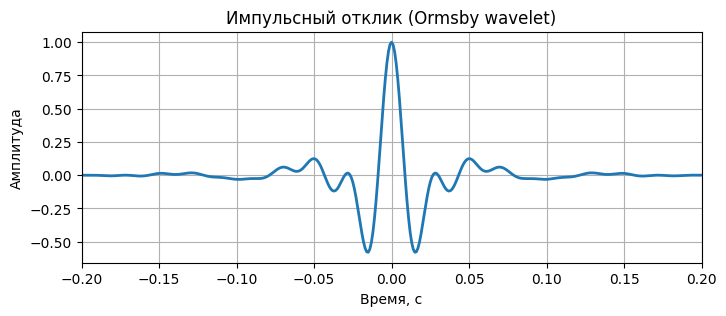

In [3]:
# параметры
f1, f2, f3, f4 = 10, 15, 40, 50
freqs, H, t, wavelet = ormsby_wavelet(f1, f2, f3, f4, dt=0.001, nt=2048)

# график частотной характеристики
plt.figure(figsize=(8,3))
plt.plot(freqs, H, lw=2)
plt.title(f"АЧХ Ormsby фильтра ({f1},{f2},{f3},{f4} Гц)")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.grid(True)
plt.xlim(0, 100)
plt.show()

# график импульсного отклика
plt.figure(figsize=(8,3))
plt.plot(t, wavelet, lw=2)
plt.title("Импульсный отклик (Ormsby wavelet)")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.grid(True)
plt.xlim(-0.2, 0.2)
plt.show()


Функции для создания фильтра Баттерфорта (нуль-фазового) и его имульсного отклика

In [4]:
from scipy.signal import butter, freqz, filtfilt

def butter_zero_phase_wavelet(f_low, f_high, fs=1000, nt=1024, order=4):
    b, a = butter(order, [f_low, f_high], btype='band', fs=fs)
    
    # импульс в центре
    imp = np.zeros(nt)
    imp[nt//2] = 1.0
    wavelet = filtfilt(b, a, imp)  # zero-phase!
    wavelet /= np.abs(wavelet).max()
    
    t = np.arange(-nt//2, nt//2) / fs
    
    # АЧХ
    w, h = freqz(b, a, worN=nt//2+1, fs=fs)
    
    return w, np.abs(h), t, wavelet


### ⚖️ Сравнение с фильтром Баттерворта

Другой популярный фильтр в геофизике — ```Butterwoth Filter``` (Фильтр Баттерворта). 
У него плавная «колоколообразная» АЧХ без резких углов. За это он даёт меньше осцилляций в импульсном отклике.

У Ормсби всё наоборот:

трапециевидная форма в спектре → более чёткая ограниченность по частотам;

зато на временной оси неизбежны осцилляции и «хвосты» вокруг основного импульса.

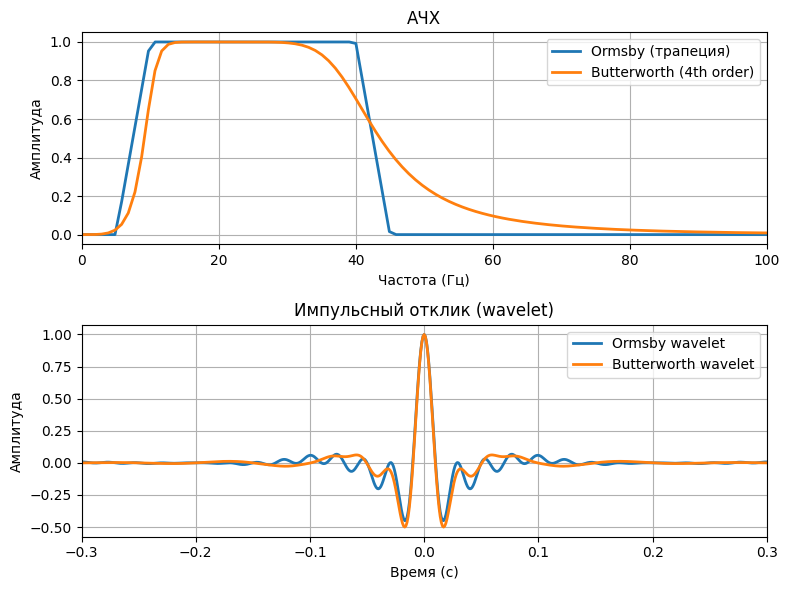

In [5]:
dt = 0.001
fs = 1 / dt  # 1000 Hz
nt = 1024

# Ormsby: резкие переходы
f1, f2, f3, f4 = 5, 10, 40, 45
freqs_o, H_o, t_o, wv_o = ormsby_wavelet(f1, f2, f3, f4, dt=dt, nt=nt)

# Butterworth: гладкие переходы
f_low, f_high = 10, 40
freqs_b, H_b, t_b, wv_b = butter_zero_phase_wavelet(f_low, f_high, fs=fs, nt=nt, order=4)

# Построение
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(freqs_o, H_o, label='Ormsby (трапеция)', lw=2)
plt.plot(freqs_b, H_b, label='Butterworth (4th order)', lw=2)
plt.xlim(0, 100)
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.title('АЧХ')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_o, wv_o, label='Ormsby wavelet', lw=2)
plt.plot(t_b, wv_b, label='Butterworth wavelet', lw=2)
plt.xlim(-0.3, 0.3)
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.title('Импульсный отклик (wavelet)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()